In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from transformers import BertTokenizer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import time
import matplotlib.pyplot as plt
from collections import defaultdict
import os

import torch
import argparse
from transformers import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
import argparse

2026-01-26 20:16:43.356396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769458603.556904      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769458603.626141      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
def main(args):
    torch.manual_seed(args.seed)
    torch.cuda.empty_cache()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    file_map = {
            "gab": '/scratch/abhatt43/HSData/Rationales_file_GAB_dataset_corrected.csv',
            "twitter": '/scratch/abhatt43/HSData/Rationales_file_TWITTER_dataset.csv',
            "reddit": '/kaggle/input/train-test-split-fixed/ChatGPT_Rationales_file_REDDIT_dataset(85-15).csv',
            "youtube": '/scratch/abhatt43/HSData/Rationales_file_YOUTUBE_dataset.csv',
            "implicit": '/scratch/abhatt43/HSData/Rationales_file_IMPLICIT_hatespeech_dataset.csv'
        }

    file_path = file_map[args.dataset]
    df = pd.read_csv(file_path)
    train_df = df[df['exp_split'] == 'train']
    test_df = df[df['exp_split'] == 'test']

    print("Train df: ", len(train_df))
    print("Test_df: ", len(test_df))

    import gc
    # del variables
    gc.collect()

    bert_model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained("GroNLP/hateBERT") ## need this for tokenizing the input text in data loader
    tokenizer_bert = AutoTokenizer.from_pretrained(bert_model_name)

    class AdditionalCustomDataset(Dataset):
        def __init__(self, texts, labels, additional_texts, tokenizer, bert_tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.additional_texts = additional_texts
            self.tokenizer = tokenizer
            self.bert_tokenizer = bert_tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            texts = self.texts[idx]
            additional_texts = self.additional_texts[idx]
            labels = self.labels[idx]
            encoding = self.tokenizer(texts, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
            additional_encoding = self.bert_tokenizer(additional_texts, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
            original_input_ids = encoding['input_ids'].squeeze()
            additional_input_ids = additional_encoding['input_ids'].squeeze()
            input_ids = torch.cat((encoding["input_ids"], additional_encoding["input_ids"]), dim=1)
            original_attention_mask = encoding['attention_mask'].squeeze()
            additional_attention_mask = additional_encoding['attention_mask'].squeeze()
            attention_mask = torch.cat((encoding["attention_mask"], additional_encoding["attention_mask"]), dim=1)
            labels = labels
            return original_input_ids, original_attention_mask, additional_input_ids, additional_attention_mask, labels
            # return input_ids, attention_mask, labels
            # return encoding, additional_encoding, labels

    #Splitting training and validation testing split to test accuracy
    if args.dataset=='implicit':
        train_text, val_texts, train_labels, val_labels = train_test_split(train_df['post'].tolist(),train_df['label'].tolist(), test_size = 0.2)
    else:
        train_text, val_texts, train_labels, val_labels = train_test_split(train_df['text'].tolist(),train_df['label'].tolist(), test_size = 0.2)
    
    add_train_text, add_val_texts, add_train_labels, add_val_labels = train_test_split(train_df['ChatGPT_Rationales'].tolist(),train_df['label'].tolist(), test_size = 0.2)


    ## Creating a CustomDataset
    train_dataset = AdditionalCustomDataset(train_text, train_labels, add_train_text, tokenizer, tokenizer_bert, max_length = 512)
    val_dataset = AdditionalCustomDataset(val_texts, val_labels, add_val_texts, tokenizer, tokenizer_bert, max_length = 512)

    #Creating dataloader object to train the model
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

    class ProjectionMLP(nn.Module):
        def __init__(self, input_size, output_size):
            super(ProjectionMLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(),
                nn.Linear(output_size, 2)
            )

        def forward(self, x):
            return self.layers(x)


    class ConcatModel(nn.Module):
        def __init__(self, hatebert_model, additional_model, projection_mlp, freeze_additional_model=True):
            super(ConcatModel, self).__init__()
            self.hatebert_model = hatebert_model
            self.additional_model = additional_model
            self.projection_mlp = projection_mlp

            if freeze_additional_model:
                for param in self.additional_model.parameters():
                    param.requires_grad = False


        def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask):
            # Forward pass through the HateBERT model
            hatebert_outputs = self.hatebert_model(input_ids=input_ids, attention_mask=attention_mask)
            hatebert_embeddings = hatebert_outputs.last_hidden_state[:, 0, :]  # Assuming [CLS] token representation
            hatebert_embeddings = torch.nn.LayerNorm(hatebert_embeddings.size()[1:]).to(device)(hatebert_embeddings.to(device)).to(device)
            # hatebert_embeddings = hatebert_embeddings.to(device)


            # Forward pass through the Additional Model
            additional_outputs = self.additional_model(input_ids=additional_input_ids, attention_mask=additional_attention_mask)
            additional_embeddings = additional_outputs.last_hidden_state[:, 0, :]  # Assuming [CLS] token representation

            additional_embeddings = torch.nn.LayerNorm(additional_embeddings.size()[1:]).to(device)(additional_embeddings.to(device)).to(device)

            # Concatenate the embeddings
            concatenated_embeddings = torch.cat((hatebert_embeddings, additional_embeddings), dim=1).to(device)
            # print("Size of concatenated embeddings:", concatenated_embeddings.size())

            # Project concatenated embeddings
            projected_embeddings = self.projection_mlp(concatenated_embeddings).to(device)

            return projected_embeddings



    hatebert_model = BertModel.from_pretrained("GroNLP/HateBERT").to(device)
    additional_model = BertModel.from_pretrained("bert-base-uncased").to(device)
    projection_mlp = ProjectionMLP(input_size=1536, output_size=512).to(device)

    freeze_flag = args.freeze.lower() if args.freeze else 'yes'  # default to 'yes'
    
    if freeze_flag == 'yes':
        concat_model = ConcatModel(hatebert_model=hatebert_model,
                                   additional_model=additional_model,
                                   projection_mlp=projection_mlp,
                                   freeze_additional_model=True)
    elif freeze_flag == 'no':
        concat_model = ConcatModel(hatebert_model=hatebert_model,
                                   additional_model=additional_model,
                                   projection_mlp=projection_mlp,
                                   freeze_additional_model=False)
    else:
        raise ValueError(f"Invalid freeze option: {args.freeze}. Must be 'yes' or 'no'.")

    concat_model = concat_model.to(device)

    optimizer = AdamW(concat_model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss().to(device)

    # criterion = criterion.to(device)

    from tqdm import tqdm
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "epoch_time": [],
        "train_throughput": [],
        "val_confidence_mean": [],
        "val_confidence_std": [],
        "gpu_memory_mb": []
    }
    
    all_epoch_val_confidences = []

    for epoch in range(args.num_epochs):
        epoch_val_confidences = []
        epoch_start_time = time.time()
        samples_seen = 0
        
        concat_model.train()

        train_losses = []
        train_accuracy = 0
        train_epoch_size = 0

        with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', dynamic_ncols=True) as loop:
            for batch in loop:
                input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch
                
                samples_seen += labels.size(0)
                
                if torch.cuda.is_available():
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    additional_input_ids = additional_input_ids.to(device)
                    additional_attention_mask = additional_attention_mask.to(device)
                    labels = labels.to(device)

                # Forward pass through the ConcatModel
                optimizer.zero_grad()
                outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
                loss = criterion(outputs, labels)
                loss = criterion(outputs.view(-1, 2), labels.view(-1)) # 2 is number of labels

                # #Added Regularization -- To reduce overfitting
                # l2_lambda = 0.01
                # l2_reg = torch.tensor(0.).to(device)
                # for param in concat_model.parameters():
                #     l2_reg += torch.norm(param)
                # loss += l2_lambda * l2_reg

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

                # Update accuracy and epoch size
                predictions = torch.argmax(outputs, dim=1)
                train_accuracy += (predictions == labels).sum().item()
                train_epoch_size += len(labels)

                # Update tqdm progress bar with set_postfix
                # loop.set_postfix(loss=loss.item(), accuracy=train_accuracy / train_epoch_size)

        epoch_train_time = time.time() - epoch_start_time
        train_throughput = samples_seen / epoch_train_time

        # Evaluation on the validation set
        concat_model.eval()

        val_predictions = []
        val_labels = []

        with torch.no_grad(), tqdm(val_dataloader, desc='Validation', dynamic_ncols=True) as loop:
            for batch in loop:
                input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch

                if torch.cuda.is_available():
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    additional_input_ids = additional_input_ids.to(device)
                    additional_attention_mask = additional_attention_mask.to(device)
                    labels = labels.to(device)

                # Forward pass through the ConcatModel
                outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
                
                probs = torch.softmax(outputs, dim=1)
                confidences, preds = torch.max(probs, dim=1)
                epoch_val_confidences.extend(confidences.cpu().numpy())

                sm = nn.Softmax(dim=1)
                predictions = torch.argmax(sm(outputs), dim=1)
                # print("prediction: ", predictions)
                # sm = nn.Softmax(dim=1)
                # predictions2 = sm(outputs)
                # print("prediction2: ", predictions2)
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate and print validation accuracy
        accuracy = accuracy_score(val_labels, val_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            val_labels, val_predictions, average='weighted'
        )
        
        print(f"Epoch {epoch + 1}:")
        print(f"  Validation Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")
        print(f"  Avg. Train Loss: {sum(train_losses) / len(train_losses):.4f}")

        epoch_time = time.time() - epoch_start_time
        conf_mean = np.mean(epoch_val_confidences)
        conf_std = np.std(epoch_val_confidences)

        
        history["train_loss"].append(np.mean(train_losses))
        history["train_acc"].append(train_accuracy / train_epoch_size)
        history["val_acc"].append(accuracy)
        history["val_precision"].append(precision)
        history["val_recall"].append(recall)
        history["val_f1"].append(f1)
        history["epoch_time"].append(epoch_time)
        history["train_throughput"].append(train_throughput)
        history["val_confidence_mean"].append(conf_mean)
        history["val_confidence_std"].append(conf_std)
        
        if torch.cuda.is_available():
            history["gpu_memory_mb"].append(
                torch.cuda.max_memory_allocated() / 1024**2
            )
            torch.cuda.reset_peak_memory_stats()
        
        print(f"  Epoch Time (s): {epoch_time:.2f}")
        print(f"  Throughput (samples/sec): {train_throughput:.2f}")
        print(f"  Val Confidence Mean: {conf_mean:.4f} ± {conf_std:.4f}")
        
    epochs = range(1, args.num_epochs + 1)

    # ---- Training Loss ----
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.show()
    
    # ---- Accuracy ----
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.show()
    
    # ---- Precision / Recall / F1 ----
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["val_precision"], label="Precision")
    plt.plot(epochs, history["val_recall"], label="Recall")
    plt.plot(epochs, history["val_f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics per Epoch")
    plt.legend()
    plt.show()
    
    # ---- Confidence Scores ----
    plt.figure(figsize=(10, 4))
    mean = np.array(history["val_confidence_mean"])
    std = np.array(history["val_confidence_std"])
    
    plt.plot(epochs, mean, label="Mean Confidence")
    plt.fill_between(epochs, mean - std, mean + std, alpha=0.3)
    plt.xlabel("Epoch")
    plt.ylabel("Confidence")
    plt.title("Validation Confidence Scores")
    plt.legend()
    plt.show()
    
    # ---- Efficiency ----
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["epoch_time"], label="Epoch Time (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.show()
    
    # ---- GPU Memory ----
    if torch.cuda.is_available():
        plt.figure(figsize=(10, 4))
        plt.plot(epochs, history["gpu_memory_mb"])
        plt.xlabel("Epoch")
        plt.ylabel("MB")
        plt.title("Peak GPU Memory Usage")
        plt.show()

    os.makedirs("/kaggle/working/models", exist_ok=True)
    
    model_save_path = (
        f"/kaggle/working/models/"
        f"concat_model_{args.dataset}_dataof8515_epochs{args.num_epochs}_seed{args.seed}.pth"
    )
    
    checkpoint = {
        "model_state_dict": concat_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": args.num_epochs,
        "dataset": args.dataset,
        "freeze": args.freeze,
        "seed": args.seed,
        "history": history
    }
    
    torch.save(checkpoint, model_save_path)
    
    print(f"\n✅ Model checkpoint saved to: {model_save_path}")
    
    print(f"\nTrained model saved to: {model_save_path}")


    if args.dataset=='implicit':
        test_texts = test_df['post'].tolist()
    else:
        test_texts = test_df['text'].tolist()

    add_test_texts = test_df['ChatGPT_Rationales'].tolist()
    test_labels = test_df['label'].tolist()

    test_dataset = AdditionalCustomDataset(test_texts, test_labels, add_test_texts, tokenizer, tokenizer_bert, max_length = 512)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

    # ================= TEST EVALUATION WITH EFFICIENCY =================
    concat_model.eval()
    test_predictions = []
    test_labels = []
    test_confidences = []
    samples_seen = 0
    test_start_time = time.time()
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    with torch.no_grad(), tqdm(test_dataloader, desc='Testing', dynamic_ncols=True) as loop:
        for batch in loop:
            input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch
    
            batch_size = labels.size(0)
            samples_seen += batch_size
    
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            additional_input_ids = additional_input_ids.to(device)
            additional_attention_mask = additional_attention_mask.to(device)
            labels = labels.to(device)
    
            outputs = concat_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                additional_input_ids=additional_input_ids,
                additional_attention_mask=additional_attention_mask
            )
    
            probs = torch.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)
    
            test_confidences.extend(confidences.cpu().numpy())
            test_predictions.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    # ================= TEST METRICS =================
    test_time = time.time() - test_start_time
    test_throughput = samples_seen / test_time
    
    accuracy = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_labels, test_predictions, average='weighted'
    )
    conf_mean = np.mean(test_confidences)
    conf_std = np.std(test_confidences)
    cm = confusion_matrix(test_labels, test_predictions)
    
    gpu_memory_mb = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    
    print("\n================= FINAL TEST RESULTS =================")
    print(f"Dataset: {args.dataset}, Seed: {args.seed}, Freeze: {args.freeze}, Epochs: {args.num_epochs}")
    print(f"Test Accuracy : {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall   : {recall:.4f}")
    print(f"Test F1-score : {f1:.4f}")
    print(f"Test Confidence Mean ± Std: {conf_mean:.4f} ± {conf_std:.4f}")
    print(f"Test Time (s) : {test_time:.2f}")
    print(f"Throughput (samples/sec) : {test_throughput:.2f}")
    print(f"Peak GPU Memory (MB) : {gpu_memory_mb:.2f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))
    print("\nConfusion Matrix:")
    print(cm)
    print("======================================================")
    


Train df:  31589
Test_df:  5575


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Validation: 100%|██████████| 790/790 [03:16<00:00,  4.03it/s]


Epoch 1:
  Validation Accuracy: 0.9223
  Precision: 0.9221
  Recall: 0.9223
  F1-score: 0.9219
  Avg. Train Loss: 0.3213
  Epoch Time (s): 2454.80
  Throughput (samples/sec): 11.19
  Val Confidence Mean: 0.9332 ± 0.1080


Validation: 100%|██████████| 790/790 [03:15<00:00,  4.05it/s]


Epoch 2:
  Validation Accuracy: 0.9429
  Precision: 0.9431
  Recall: 0.9429
  F1-score: 0.9425
  Avg. Train Loss: 0.1211
  Epoch Time (s): 2456.78
  Throughput (samples/sec): 11.17
  Val Confidence Mean: 0.9668 ± 0.0773


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


Epoch 3:
  Validation Accuracy: 0.9438
  Precision: 0.9437
  Recall: 0.9438
  F1-score: 0.9436
  Avg. Train Loss: 0.0484
  Epoch Time (s): 2454.93
  Throughput (samples/sec): 11.19
  Val Confidence Mean: 0.9822 ± 0.0636


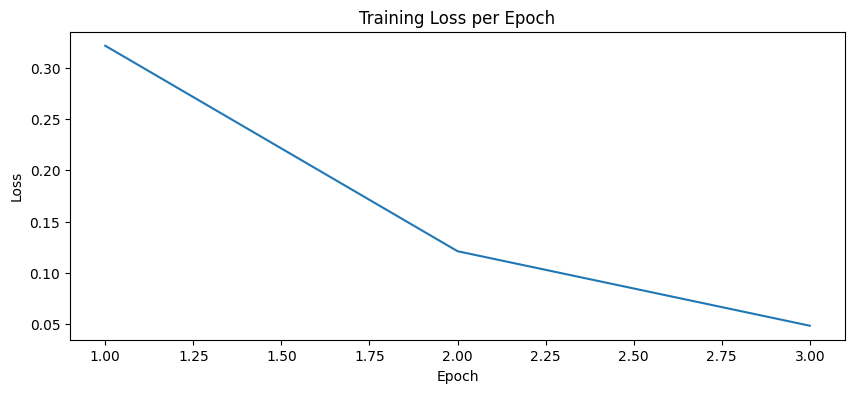

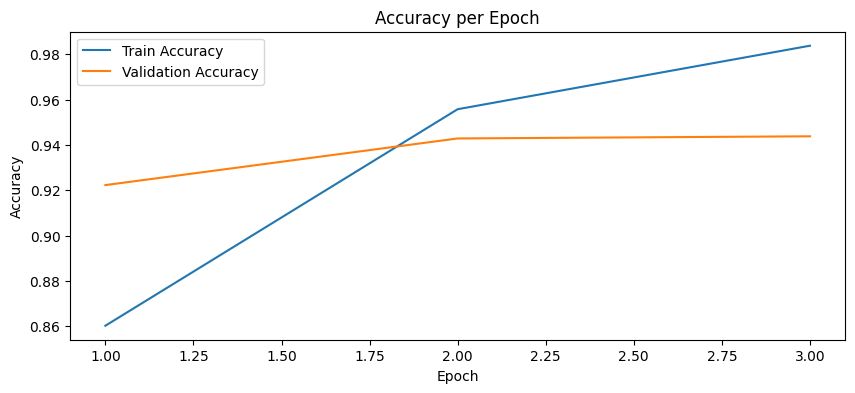

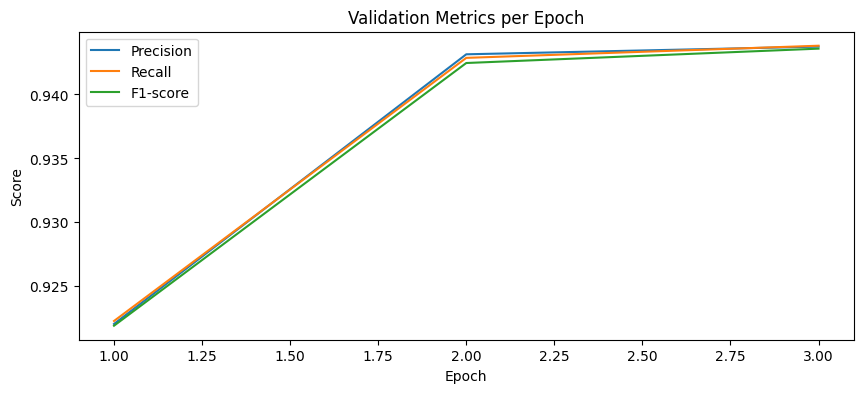

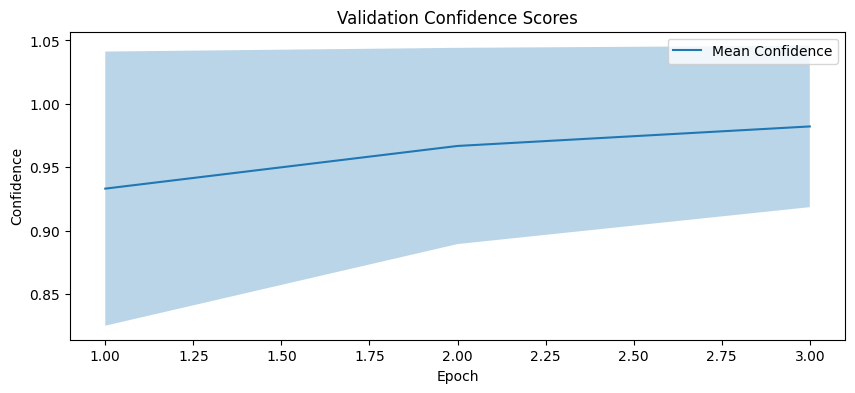

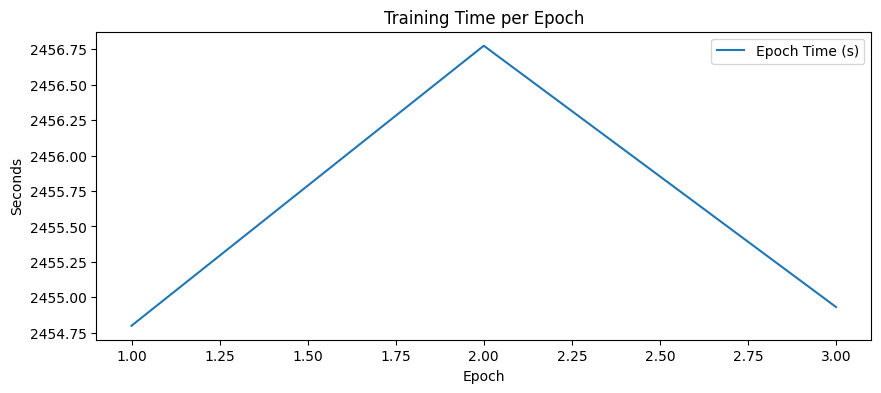

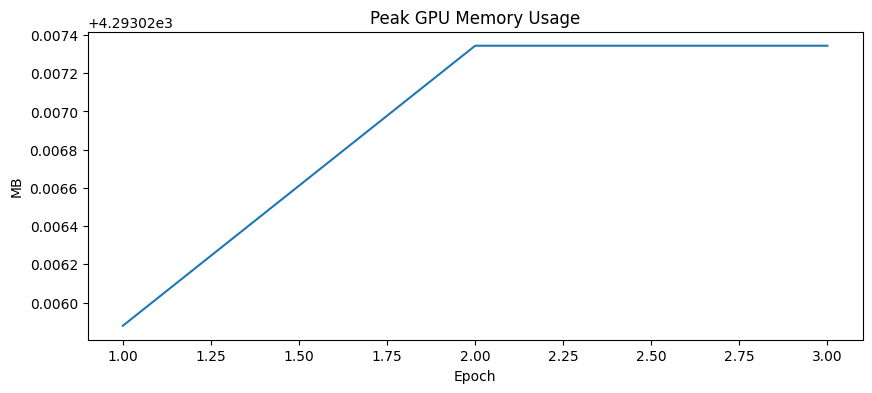


✅ Model checkpoint saved to: /kaggle/working/models/concat_model_reddit_dataof8515_epochs3_seed42.pth

Trained model saved to: /kaggle/working/models/concat_model_reddit_dataof8515_epochs3_seed42.pth


Testing: 100%|██████████| 2788/2788 [03:19<00:00, 13.95it/s]


================= FINAL TEST RESULTS =================
Dataset: reddit, Seed: 42, Freeze: None, Epochs: 3
Test Accuracy : 0.9435
Test Precision: 0.9434
Test Recall   : 0.9435
Test F1-score : 0.9433
Test Confidence Mean ± Std: 0.9833 ± 0.0599
Test Time (s) : 199.90
Throughput (samples/sec) : 27.89
Peak GPU Memory (MB) : 2209.59

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3513
           1       0.94      0.91      0.92      2062

    accuracy                           0.94      5575
   macro avg       0.94      0.94      0.94      5575
weighted avg       0.94      0.94      0.94      5575


Confusion Matrix:
[[3392  121]
 [ 194 1868]]


In [3]:
if __name__=="__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument('--num_epochs', type=int, default=3)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--dataset', type=str, default='reddit')
    parser.add_argument('--freeze', type=str, choices=['yes','no'])  # whether to freeze additional bert model

    # Ignore unknown args (like -f from Jupyter/Colab)
    args, unknown = parser.parse_known_args()

    main(args)
